In [1]:
from typing import Tuple
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from utils import *


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [24]:

class HorizontalDataset(Dataset):
    def __init__(self, dataFrames) -> None:

        newDataFrames = []
        for df in dataFrames:
            df = df[['LeftPressed', 'RightPressed', 'SprintPressed', 'OnGround', 'OnWall', 'Jumping', 'VelocityX']]
            df['VelocityX'] = df['VelocityX'] / 12.8
            df = df.shift(1).join(df['VelocityX'], rsuffix='_next').reset_index(drop=True).drop(0, axis=0).reset_index(drop=True)
            newDataFrames.append(df)


        data = pd.concat(newDataFrames)\
            .drop_duplicates(subset=['LeftPressed', 'RightPressed', 'SprintPressed', 'OnGround', 'OnWall', 'Jumping', 'VelocityX', 'VelocityX_next'])\
            .drop_duplicates(subset=['VelocityX', 'VelocityX_next'])
        
        self.labels = torch.tensor(data['VelocityX_next'].to_numpy(), dtype=torch.float32).to(device)
        self.features = torch.tensor(data[['LeftPressed', 'RightPressed', 'SprintPressed', 'OnGround', 'OnWall', 'Jumping', 'VelocityX']].to_numpy(dtype=float), dtype=torch.float32).to(device)
        self.num_samples = len(data)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.features[idx], self.labels[idx]
    

In [32]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(7, 32)
        self.fc2 = nn.Linear(32, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 32)
        self.fc5 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))        
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x.squeeze(1)

In [13]:

# train_size = int(0.8 * len(dataset))

# train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, len(dataset) - train_size])


In [33]:
dataset = HorizontalDataset([
    load_latest_results('NN_HorizontalGroundAccelerationTests', skip_time_steps=5),
    load_latest_results('NN_HorizontalAirAccelerationTests', skip_time_steps=6)
])

train_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

net = Net().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

for epoch in range(1000):
    for i, data in enumerate(train_dataloader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs.float())
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch} loss: {loss.item()}')

print('Finished Training')

Epoch 0 loss: 0.29086655378341675
Epoch 10 loss: 0.006928015500307083
Epoch 20 loss: 0.0051133520901203156
Epoch 30 loss: 0.003777785925194621
Epoch 40 loss: 0.003065668512135744
Epoch 50 loss: 0.003904154058545828
Epoch 60 loss: 0.0040692961774766445
Epoch 70 loss: 0.0022133467718958855
Epoch 80 loss: 0.002366703934967518
Epoch 90 loss: 0.0019597967620939016
Epoch 100 loss: 0.0034821636509150267
Epoch 110 loss: 0.003214807016775012
Epoch 120 loss: 0.002648323541507125
Epoch 130 loss: 0.0014757533790543675
Epoch 140 loss: 0.0015569444512948394
Epoch 150 loss: 0.0010546466801315546
Epoch 160 loss: 0.0015300116501748562
Epoch 170 loss: 0.002354762749746442
Epoch 180 loss: 0.0030501193832606077
Epoch 190 loss: 0.0012169377878308296
Epoch 200 loss: 0.0017959732795134187
Epoch 210 loss: 0.0028262741398066282
Epoch 220 loss: 0.0021440954878926277
Epoch 230 loss: 0.0019746364559978247
Epoch 240 loss: 0.0028465588111430407
Epoch 250 loss: 0.0010053787846118212
Epoch 260 loss: 0.002115438692271

In [34]:

correct = 0

with torch.no_grad():
    for i, data in enumerate(test_dataloader):
        inputs, labels = data
        outputs = net(inputs.float())
        correct += (outputs.round() == labels).sum().item()


print(f'Accuracy: {correct / len(dataset)}')


Accuracy: 0.024942263279445726


In [35]:
def plot(df, scenario):
    
    df = df[df['ScenarioName'] == scenario]
    df = df[['LeftPressed', 'RightPressed', 'SprintPressed', 'OnGround', 'OnWall', 'Jumping', 'VelocityX']]

    dataset = HorizontalDataset([df])
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

    x = []
    y1 = []
    y2 = []

    with torch.no_grad():
        for i, data in enumerate(dataloader):
            inputs, labels = data
            outputs = net(inputs.float())
            x.append(i)
            y1.append(outputs.cpu().numpy() * 12.8)
            y2.append(labels.cpu().numpy() * 12.8)
            # plt.plot(i, outputs.cpu().numpy(), label='Predicted')
            # plt.plot(i, labels.cpu().numpy(), '-o', label='Actual')

    plt.plot(x, y1, label='Predicted')
    plt.plot(x, y2, '-', label='Actual')
    plt.legend()
    plt.title(scenario)

['recording']


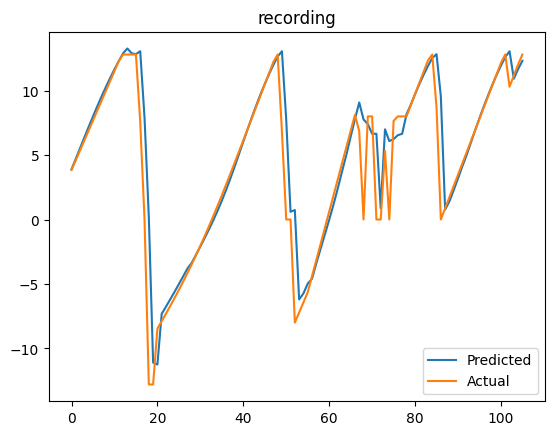

In [36]:

df = load_latest_results('Game_Recording', skip_time_steps=5)
print(df['ScenarioName'].unique())

plot(df, 'recording')

In [ ]:
vX = 0

for t in range(0, 15):
    # 'LeftPressed', 'RightPressed', 'SprintPressed', 'OnGround', 'Jumping', 'VelocityX'
    x = torch.tensor([0, 1, 0, 1, 0, vX], dtype=torch.float32).to(device).reshape((1, 6))
    vX_next = net(x).to('cpu').item()
    plt.plot(t, vX_next, 'bo')
    vX = vX_next

for t in range(15, 60):
    # 'LeftPressed', 'RightPressed', 'SprintPressed', 'OnGround', 'Jumping', 'VelocityX'
    x = torch.tensor([1, 0, 1, 1, 0, vX], dtype=torch.float32).to(device).reshape((1, 6))
    vX_next = net(x).to('cpu').item()
    plt.plot(t, vX_next, 'bo')
    vX = vX_next

